In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt

In [2]:
# define potential for training data
def v(x, choice=0):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # symmetric double well potential
        return 0.0025 * (x ** 2 - 25) ** 2
    elif choice == 2:
        # asymmetric double well potential
        return 0.0003 * ((x - 3) ** 4 + 10 * (x - 5) ** 3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x ** 2 + 0.25)
    else:
        print('Function v(x, choice=0): Did not recognise your input for choice.')

In [3]:
# set L of spatial domain
L = 15
# create vector of real space points for plotting
nx = 1024
xvec = np.linspace(-L, L, nx)

In [56]:
# set highest value for index of Gaussian basis
J = 25  # 100
# make vector of j values
xjvec, testh = np.linspace(-L, L, 2 * J + 1, retstep=True)
# check if jvec = n = 2 J + 1
print(f'Size xjvec: {len(xjvec)}, n: {2 * J + 1}')
# check if first value of xjvec = -L and last value = L
print(f'L: {L}, First val xjvec: {xjvec[0]}, Last val xjvec: {xjvec[-1]}')
# check if true h and returned step value agree
print(f'L / J: {L / J}, step size: {testh}')

Size xjvec: 51, n: 51
L: 15, First val xjvec: -15.0, Last val xjvec: 15.0
L / J: 0.6, step size: 0.6


In [57]:
# define Gaussian basis function
def gb(x, jh, alpha):
    return np.exp(-alpha * (x - jh) ** 2)

# set fixed alpha
fixedalpha = 1  # 4.0 * np.log(2) / testh ** 2  # 60.0

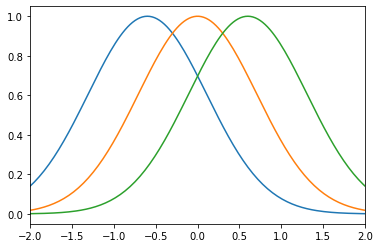

In [58]:
for thisj in range(-1, 2):
    plt.plot(xvec, gb(xvec, thisj*testh, fixedalpha))

plt.xlim(-2, 2)
plt.show()

In [59]:
# make matrix of x values on the j grid
xjmat = np.broadcast_to(xjvec, (len(xjvec), len(xjvec)))
# show what the first element of xjmat looks like
print(xjmat[0])
# show what the first element of xjmat.T looks like
print(xjmat.T[0])
# make Gaussian basis matrix.
# We want gbmat @ gbcfs = vtrue, so each row in gbmat is
# all the Gaussian basis for one value of x
gbmat = gb(xjmat.T, xjmat, fixedalpha)
# check shape of gbmat, should be (n x n)
print(f'n: {2 * J + 1}, gbmat dim: {gbmat.shape}')

[-15.  -14.4 -13.8 -13.2 -12.6 -12.  -11.4 -10.8 -10.2  -9.6  -9.   -8.4
  -7.8  -7.2  -6.6  -6.   -5.4  -4.8  -4.2  -3.6  -3.   -2.4  -1.8  -1.2
  -0.6   0.    0.6   1.2   1.8   2.4   3.    3.6   4.2   4.8   5.4   6.
   6.6   7.2   7.8   8.4   9.    9.6  10.2  10.8  11.4  12.   12.6  13.2
  13.8  14.4  15. ]
[-15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15. -15.
 -15. -15. -15. -15. -15. -15. -15. -15. -15.]
n: 51, gbmat dim: (51, 51)


In [60]:
# compute true potential
vchoice = 1
vtruexjvec = v(x=xjvec, choice=vchoice)
# check that vtruexjvec has the same dim as n
print(f'n: {2 * J + 1}, vtruexjvec dim: {len(vtruexjvec)}')
# compute the Gaussian basis coefficients using numpy.linalg.solve
vgbcoefsol = nl.solve(gbmat, vtruexjvec)
# compute the Gaussian basis coefficients using numpy.linalg.inv
vgbcoefinv = nl.inv(gbmat) @ vtruexjvec
# print norm of difference between solutions
print(f'Norm diff sol methods: {nl.norm(vgbcoefsol - vgbcoefinv)}')

n: 51, vtruexjvec dim: 51
Norm diff sol methods: 2.1749134664495884e-12


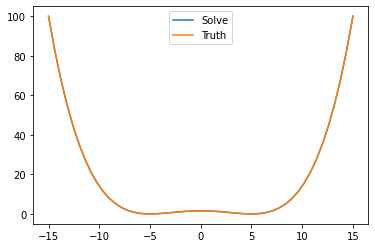

In [61]:
# reconstruct potential from Gaussian basis coefficients
vsol = gbmat @ vgbcoefsol
vinv = gbmat @ vgbcoefinv
# plot the true potential vs reconstruction of both solutions
plt.plot(xjvec, vsol, label='Solve')
# plt.plot(xjvec, vinv, label='Inverse')
plt.plot(xjvec, vtruexjvec, label='Truth')
plt.legend()
plt.show()

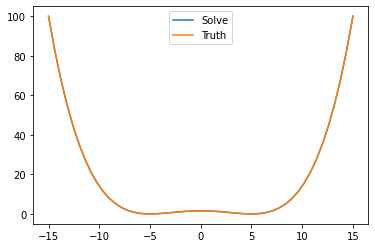

In [62]:
# The Gaussian basis function is defined as
# def gb(x, jh, alpha):
#     return np.exp(-alpha * (x - jh) ** 2)

# functional representation in the Gaussian basis
def fprx(thisx):
    return np.sum(gb(thisx, xjvec, alpha=fixedalpha) @ vgbcoefsol)

# function representation of L2 norm
def integrand(thisx):
    return (v(x=thisx, choice=vchoice) - fprx(thisx))**2

# plot functional representation vs truth
fnresol = np.zeros_like(xjvec)
for j in range(len(xjvec)):
    thisxj = xjvec[j]
    fnresol[j] = fprx(thisxj)
plt.plot(xjvec, fnresol, label='Solve')
plt.plot(xjvec, vtruexjvec, label='Truth')
plt.legend()
plt.show()

In [63]:
# compute vector L2 error for solve solution
print(f'Vec norm (sol): {nl.norm(vtruexjvec - vsol)}')
# compute real L2 norm
L2norm = np.sqrt(si.romberg(integrand, a=-L, b=L, divmax=20))
print (f'L2 norm (sol): {L2norm}')
# compute vector L2 error for inv solution
# print(f'Norm diff inv: {nl.norm(vtruexjvec - vinv)}')

Vec norm (sol): 3.1396522060491424e-14
L2 norm (sol): 3.1776437161565096e-14


---

In [48]:
# function for computing the L2 error given some number of basis
def error(thisvchoice = 1, thisfixedalpha = 1, thisJ = 100, thisL = 15):
    # make vector of j values
    thisxjvec, thish = np.linspace(-thisL, thisL, 2 * thisJ + 1, retstep=True)
    # make matrix of x values on the j grid
    thisxjmat = np.broadcast_to(thisxjvec, (len(thisxjvec), len(thisxjvec)))
    # compute the true potential using thisxjvec values
    thisvtruexjvec = v(x=thisxjvec, choice=thisvchoice)
    # make Gaussian basis matrix.
    # We want gbmat @ gbcfs = vtrue, so each row in gbmat is
    # all the Gaussian basis for one value of x
    thisgbmat = gb(thisxjmat.T, thisxjmat, thisfixedalpha)
    # compute the Gaussian basis coefficients using numpy.linalg.solve
    thisvgbcoefsol = nl.solve(thisgbmat, thisvtruexjvec)
    # compute the Gaussian basis coefficients using numpy.linalg.inv
    thisvgbcoefinv = nl.inv(thisgbmat) @ thisvtruexjvec
    # reconstruct potential from Gaussian basis coefficients
    thisvsol = thisgbmat @ thisvgbcoefsol
    thisvinv = thisgbmat @ thisvgbcoefinv
    # return L2 error for both solution methods
    return [nl.norm(thisvtruexjvec - thisvsol), nl.norm(thisvtruexjvec - thisvinv), thish]

In [49]:
# check that error function produces same results as above
print(error(thisvchoice = 1, thisfixedalpha = 4.0 * np.log(2) / testh ** 2, thisJ = 100, thisL = 15))

[0.0, 0.0, 0.15]


In [50]:
# set number of results
numres = 10

# initialize array for storing results
errorvec = []

# loop for investigating order of accuracy
# error as a function of h
# for loop sets the number of Gaussian basis
for i in np.arange(numres):
    forJ = 2**(3 + i)
    print(f'Computing Result {i+1} of {numres}')
    thiserror = error(thisvchoice = 1, thisfixedalpha = 1, thisJ = forJ, thisL = 15)
    # print(thiserror)
    errorvec.append(thiserror)

errorvec = np.array(errorvec)
print(errorvec.shape)

Computing Result 1 of 10
Computing Result 2 of 10
Computing Result 3 of 10
Computing Result 4 of 10
Computing Result 5 of 10
Computing Result 6 of 10
Computing Result 7 of 10
Computing Result 8 of 10
Computing Result 9 of 10
Computing Result 10 of 10


KeyboardInterrupt: 

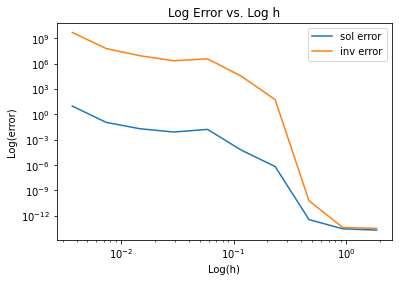

In [16]:
plt.loglog(errorvec[:,-1], errorvec[:,0], label='sol error')
plt.loglog(errorvec[:,-1], errorvec[:,1], label='inv error')
plt.title('Log Error vs. Log h')
plt.xlabel('Log(h)')
plt.ylabel('Log(error)')
plt.legend()
plt.show()
#plt.savefig('./order-of-accuracy-results/error-vs-h-plot.pdf')